In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d andrewmvd/face-mask-detection

100%|██████████| 398M/398M [00:12<00:00, 33.5MB/s]


In [2]:
!unzip face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import xml.etree.ElementTree as ET
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score,  recall_score, accuracy_score, f1_score, classification_report
import cv2 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [6]:
no_mask_path = "annotations/"
mask_path = "images/"
images = [*os.listdir("images/")]
output_path = "."

In [9]:
img_masks = []
mask_label = []
for i in os.listdir(mask_path):
  img = os.path.join(mask_path + "/", i)
  img_masks.append(img)
  mask_label.append("mask")

image_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path):
  img = os.path.join(no_mask_path + "/", i)
  image_no_mask.append(img)
  target_no_mask.append("without_mask")

mask_df = pd.DataFrame()
mask_df["image"] = img_masks
mask_df['target'] = mask_label
no_mask_df = pd.DataFrame()
no_mask_df['image'] = image_no_mask
no_mask_df["target"] = target_no_mask
df = pd.concat([mask_df, no_mask_df], axis=0, ignore_index=True)
df = shuffle(df)

In [10]:
df.shape

(1706, 2)

In [11]:
df.head()

,image,target
334,images//maksssksksss790.png,mask
58,images//maksssksksss32.png,mask
1116,annotations//maksssksksss166.xml,without_mask
958,annotations//maksssksksss758.xml,without_mask
967,annotations//maksssksksss212.xml,without_mask


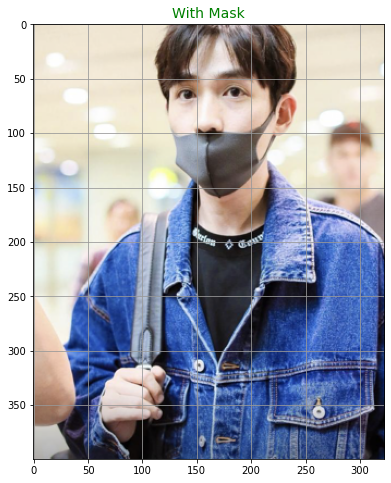

In [12]:
plt.figure(figsize=(12,8))
img = load_img(mask_df["image"][1])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

In [13]:
def parse_annonation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result 




In [14]:
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params 

In [15]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [17]:
dataset = [parse_annonation(anno) for anno in glob.glob(no_mask_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)

In [18]:
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss554,400,281,3,with_mask,96,44,117,73
1,maksssksksss554,400,281,3,with_mask,84,162,106,182
2,maksssksksss554,400,281,3,with_mask,167,50,193,83
3,maksssksksss554,400,281,3,with_mask,229,24,265,71
4,maksssksksss554,400,281,3,with_mask,265,57,289,89


In [19]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [20]:
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'Name')

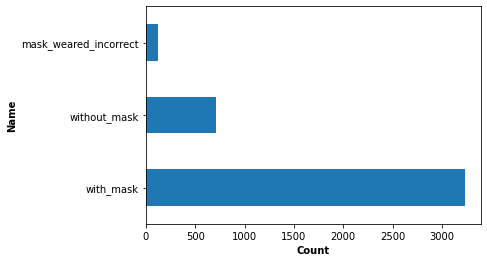

In [21]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Name', fontsize = 10, fontweight = 'bold')

In [22]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [23]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [24]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(mask_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [25]:
cropped_faces = [extract_faces(img, df) for img in images]

In [26]:
flat_cropped_faces = sum(cropped_faces, [])

In [27]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [28]:
print(len(mask_weared_incorrect))


123


In [29]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [30]:
print("Size of Train Set with No_Mask :",len(train_without_mask))
print("Size of Test Set with No_Mask :",len(test_without_mask))
print("Size of Validation Set with No_Mask :",len(val_without_mask))

Size of Train Set with No_Mask : 572
Size of Test Set with No_Mask : 42
Size of Validation Set with No_Mask : 101


In [31]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [32]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [33]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [35]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [36]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [37]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [39]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [40]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50
50/50 [==============================] - 12s 33ms/step - loss: 0.5629 - accuracy: 0.8065 - recall: 0.7663 - precision: 0.8177 - auc: 0.9168 - val_loss: 0.5798 - val_accuracy: 0.7778 - val_recall: 0.7778 - val_precision: 0.7778 - val_auc: 0.9292 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 18ms/step - loss: 0.5260 - accuracy: 0.8065 - recall: 0.7889 - precision: 0.8329 - auc: 0.9289 - val_loss: 0.4500 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8194 - val_auc: 0.9567 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 18ms/step - loss: 0.3477 - accuracy: 0.8725 - recall: 0.8700 - precision: 0.8878 - auc: 0.9686 - val_loss: 0.4325 - val_accuracy: 0.8472 - val_recall: 0.8472 - val_precision: 0.8472 - val_auc: 0.9521 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 19ms/step - loss: 0.3684 - accuracy: 0.8950 - recall: 0.8775 - precision: 0.9046 - auc: 0.9616 - val_loss: 0.3074 - val_accuracy: 0.8611 - v

In [41]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)

31/31 [==============================] - 0s 11ms/step - loss: 0.1788 - accuracy: 0.9424 - recall: 0.9383 - precision: 0.9461 - auc: 0.9902


31/31 [==============================] - 1s 13ms/step
Class Predicted: with_mask , True label: with_mask


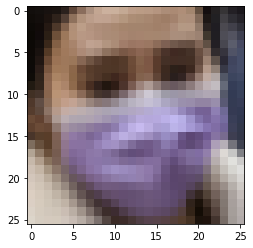

In [42]:

paths = test_generator.filenames 

 

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

 

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

 

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')


1/1 [==============================] - 0s 30ms/step


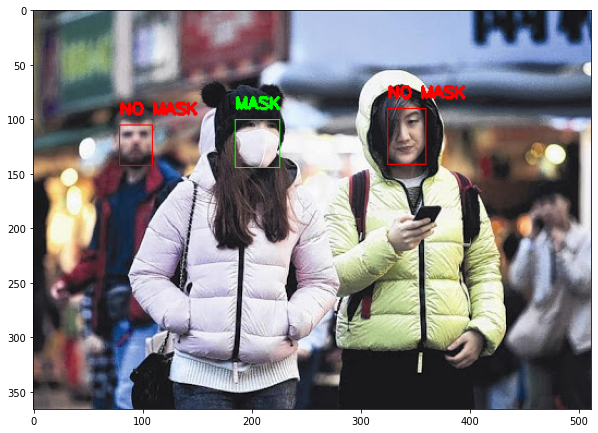

In [43]:
import cv2
img = cv2.imread(os.path.join(mask_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'name']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()])

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)